In [13]:
PLAYER_NAME = "Dave"                # Player of interest
ENGINE_NAME = "stockfish"           # Engine for single engine analysis
ENGINES = [ENGINE_NAME]             # Engines for which to retrieve game analyses
QUANTILE = 0.05                     # Best and worst Q% of games
R_MIN = 800                         # Floor for the worst performances
R_MAX = 2300                        # Ceiling for the best performances
EPSILON = 0.01                      # How close can get worst games get to R_min + epsilon*(R_max - R_min)

In [14]:
%run constants.ipynb
%run database.ipynb
%run analysis.ipynb
%run pathutils.ipynb
%run export.ipynb

1. Generate the ACPL data set for the specified player and engines
2. Extract the ACPL values for the single engine of interest
3. Determine the best and worst games
4. Calculate K

In [15]:
import numpy as np

# Generate the ACPL data set
connection = connect()
player_acpl_df = generate_acpl_for_player(connection, PLAYER_NAME, ENGINES, 1)

# Extract the ACPL values for the engine of interest
df = player_acpl_df[player_acpl_df["engine"] == ENGINE_NAME].copy()

# Get the best and worst Q% of games
ACPL_best = df["acpl"].quantile(QUANTILE)
ACPL_worst = df["acpl"].quantile(1.00 - QUANTILE)

# K defines how quickly Elo drops as ACPL increases
K = np.log(1/EPSILON) / (ACPL_worst - ACPL_best)

print(f'ACPL(best) is {ACPL_best}')
print(f"K for games played by {PLAYER_NAME} and anlysed using {ENGINE_NAME} is {K}")

ACPL(best) is 12.534693877551021
K for games played by Dave and anlysed using stockfish is 0.04718427294310742


Having calculated "k" and determined "ACPL_best", the function personal_elo_single_engine() provides a way of estimating ELO for a game with ACPL equal to "acpl"

In [16]:
def personal_elo_single_engine(acpl, ACPL_best=ACPL_best):
    return R_MIN + (R_MAX - R_MIN) * np.exp(-K * (acpl - ACPL_best))

df["elo_personal_single"] = personal_elo_single_engine(df["acpl"])
display(df)

,game_id,engine,depth,acpl,acpl_z,elo_personal_single
0,1,stockfish,0,91.680000,1.390843,835.830757
1,2,stockfish,0,112.692308,2.093180,813.294577
2,3,stockfish,0,22.057692,-0.936284,1757.077748
3,4,stockfish,0,79.285714,0.976564,864.304012
4,5,stockfish,0,67.312500,0.576359,913.133601
...,...,...,...,...,...,...
160,162,stockfish,0,20.160000,-0.999714,1846.729543
161,163,stockfish,0,5.818182,-1.479090,2859.326209
162,164,stockfish,0,39.333333,-0.358845,1223.581555
163,165,stockfish,0,13.360000,-1.227004,2242.710504


Export the per-game Elo ratings and model parameters to a spreadsheet

In [17]:
import pandas as pd

parameters_df = pd.DataFrame(columns=["R_Min", "R_Max", "K", "ACPL_best"])
parameters_df.loc[len(parameters_df)] = [R_MIN, R_MAX, K, ACPL_best]

export_to_spreadsheet(f"single-engine-model-{ENGINE_NAME}", {
    "Parameters": parameters_df,
    "Per Game Elo": df
})

A smoothed density plot shows the structure of ACPL values more clearly than a histogram and helping to motivate the exponential decay model

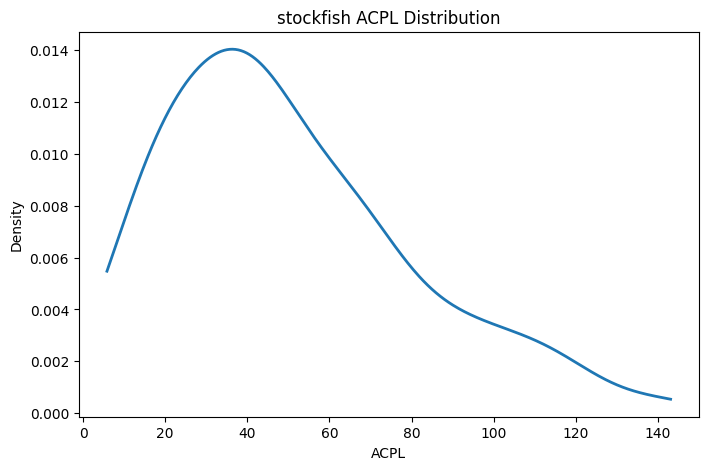

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# ACPL values
acpl = df["acpl"].values

# KDE
kde = gaussian_kde(acpl)

x = np.linspace(acpl.min(), acpl.max(), 400)
y = kde(x)

plt.figure(figsize=(8, 5))
plt.plot(x, y, linewidth=2)
plt.xlabel("ACPL")
plt.ylabel("Density")
plt.title(f"{ENGINE_NAME} ACPL Distribution")

# Export the chart
export_chart("acpl-distribution", ENGINE_NAME, "png")

plt.show()

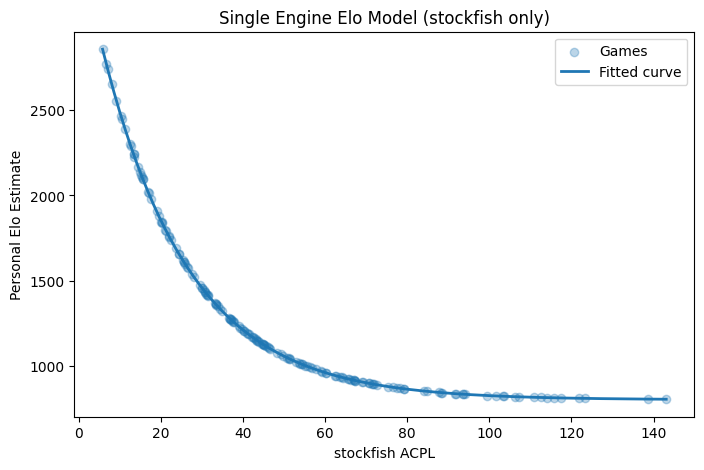

In [19]:
import matplotlib.pyplot as plt

acpl_range = np.linspace(df["acpl"].min(), df["acpl"].max(), 200)
elo_curve = personal_elo_single_engine(acpl_range)

plt.figure(figsize=(8, 5))
plt.scatter(df["acpl"], df["elo_personal_single"], alpha=0.3, label="Games")
plt.plot(acpl_range, elo_curve, linewidth=2, label="Fitted curve")
plt.xlabel(f"{ENGINE_NAME} ACPL")
plt.ylabel("Personal Elo Estimate")
plt.title(f"Single Engine Elo Model ({ENGINE_NAME} only)")
plt.legend()

# Export the chart
export_chart("single-engine-model", ENGINE_NAME, "png")

plt.show()